In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time


In [157]:
class QuantizationLayer(nn.Module):
    def __init__(self, bit_precisions):
        super(QuantizationLayer, self).__init__()
        self.bit_precisions = bit_precisions

    def forward(self, weights, bit_precision):
        if bit_precision not in self.bit_precisions:
            raise ValueError(f"Unsupported bit precision: {bit_precision}")

        # MAX_N for N-bit quantization
        max_n = 2 ** bit_precision - 1

        # Normalize weights using tanh and map to [0, 1]
        normalized_weights = (torch.tanh(weights) / (2 * torch.max(torch.abs(torch.tanh(weights))))) + 0.5

        # Quantize to N-bit fixed-point
        quantized_weights = torch.round(normalized_weights * max_n)

        # Re-map to approximate original weight range
        weights_quantized = 2 * quantized_weights / max_n - 1

        return weights_quantized



In [158]:
bit_precisions = [4, 8, 16, 32]
class APNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bit_precisions=bit_precisions):
        super(APNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.quant_layer = QuantizationLayer(bit_precisions)
        self.bit_precisions = bit_precisions

        # Separate BatchNorm layers for each precision
        self.batchnorms = nn.ModuleDict({
            f"bn_{bit}": nn.BatchNorm1d(hidden_dim) for bit in bit_precisions
        })

    def forward(self, x, bit_precision):
        if bit_precision not in self.bit_precisions:
            raise ValueError(f"Unsupported bit precision: {bit_precision}")

        # Apply first layer
        x = F.relu(self.fc1(x))

        # Apply corresponding BatchNorm layer
        bn_layer = self.batchnorms[f"bn_{bit_precision}"]
        x = bn_layer(x)

        # Quantize the output
        x = self.quant_layer(x, bit_precision)

        # Apply second layer and output
        x = torch.sigmoid(self.fc2(x))
        return x



In [159]:


# Prepare data
def prepare_data():
    X, y = make_classification(n_samples=20000, n_features=32, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    return X_train, X_test, y_train, y_test


In [160]:


# Loss Function with Distillation
def compute_loss(outputs, labels, teacher_outputs, lambda_distill=0.5):
    task_loss = F.binary_cross_entropy(outputs, labels)
    distill_loss = F.mse_loss(outputs, teacher_outputs)
    return task_loss + lambda_distill * distill_loss


In [161]:

# Train function updated with BatchNorm replacement
def train_apnn_with_batchnorm(model, X_train, y_train, epochs=50, lr=0.01, lambda_distill=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    bit_precisions = model.bit_precisions
    teacher_precision = max(bit_precisions)
    student_precisions = bit_precisions[:-1]

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Sample a batch of data
        teacher_outputs = model(X_train, teacher_precision)

        total_loss = 0
        for precision in student_precisions:
            # Replace BatchNorm for the given precision
            student_outputs = model(X_train, precision)

            # Compute loss
            loss = compute_loss(student_outputs, y_train, teacher_outputs, lambda_distill)
            total_loss += loss

        total_loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.item():.4f}")


In [162]:


# Evaluate the APNN Model
def evaluate_apnn(model, X_test, y_test, bit_precision):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test, bit_precision)
        test_accuracy = ((test_outputs > 0.5) == y_test).float().mean().item()
    return test_accuracy



In [163]:

# Main Execution
input_dim = 32
hidden_dim = 64
output_dim = 1
bit_precisions = [4, 8, 16, 32]

X_train, X_test, y_train, y_test = prepare_data()


In [164]:

# Initialize APNN Model
apnn_model = APNN(input_dim, hidden_dim, output_dim, bit_precisions)


In [165]:

# Train APNN
train_apnn_with_batchnorm(apnn_model, X_train, y_train, epochs=100, lr=0.01, lambda_distill=0.5)


Epoch 1/100, Loss: 2.0041
Epoch 6/100, Loss: 1.6936
Epoch 11/100, Loss: 1.5443
Epoch 16/100, Loss: 1.4638
Epoch 21/100, Loss: 1.4086
Epoch 26/100, Loss: 1.3679
Epoch 31/100, Loss: 1.3381
Epoch 36/100, Loss: 1.3158
Epoch 41/100, Loss: 1.2985
Epoch 46/100, Loss: 1.2852
Epoch 51/100, Loss: 1.2750
Epoch 56/100, Loss: 1.2670
Epoch 61/100, Loss: 1.2605
Epoch 66/100, Loss: 1.2552
Epoch 71/100, Loss: 1.2509
Epoch 76/100, Loss: 1.2474
Epoch 81/100, Loss: 1.2444
Epoch 86/100, Loss: 1.2418
Epoch 91/100, Loss: 1.2396
Epoch 96/100, Loss: 1.2378


In [166]:
# Evaluate APNN at Different Bit Precisions
for bit_precision in bit_precisions:
    accuracy = evaluate_apnn(apnn_model, X_test, y_test, bit_precision)
    print(f"Bit Precision: {bit_precision}, Test Accuracy: {accuracy:.4f}")


Bit Precision: 4, Test Accuracy: 0.8238
Bit Precision: 8, Test Accuracy: 0.8259
Bit Precision: 16, Test Accuracy: 0.8259
Bit Precision: 32, Test Accuracy: 0.8259


In [167]:
import torch
import matplotlib.pyplot as plt
import time

# Measure inference time for each bit precision
def measure_inference_time(model, X_test, bit_precision, device='cuda'):
    model.to(device)
    X_test_cuda = X_test.to(device)

    # Warm-up for stable measurements
    for _ in range(10):
        with torch.no_grad():
            model(X_test_cuda, bit_precision)

    # Measure inference time
    torch.cuda.synchronize() if device == 'cuda' else None
    start_time = time.time()

    with torch.no_grad():
        outputs = model(X_test_cuda, bit_precision)

    torch.cuda.synchronize() if device == 'cuda' else None
    end_time = time.time()

    # Return inference time
    inference_time = end_time - start_time
    return inference_time

# Define bit precisions
bit_precisions = [32, 16, 8, 4]

# Measure inference times
inference_times = []
for bit_precision in bit_precisions:
    print(f"Measuring inference time for bit precision: {bit_precision}")
    inference_time = measure_inference_time(apnn_model, X_test, bit_precision, device='cuda')
    inference_times.append(inference_time)
    print(f"Bit Precision: {bit_precision}, Inference Time: {inference_time:.6f} seconds")



Measuring inference time for bit precision: 32
Bit Precision: 32, Inference Time: 0.000500 seconds
Measuring inference time for bit precision: 16
Bit Precision: 16, Inference Time: 0.000423 seconds
Measuring inference time for bit precision: 8
Bit Precision: 8, Inference Time: 0.000465 seconds
Measuring inference time for bit precision: 4
Bit Precision: 4, Inference Time: 0.000432 seconds


Bit Precision: 32, Accuracy: 0.8259, Inference Time: 0.000445 seconds
Bit Precision: 16, Accuracy: 0.8259, Inference Time: 0.000435 seconds
Bit Precision: 8, Accuracy: 0.8259, Inference Time: 0.000432 seconds
Bit Precision: 4, Accuracy: 0.8238, Inference Time: 0.000413 seconds


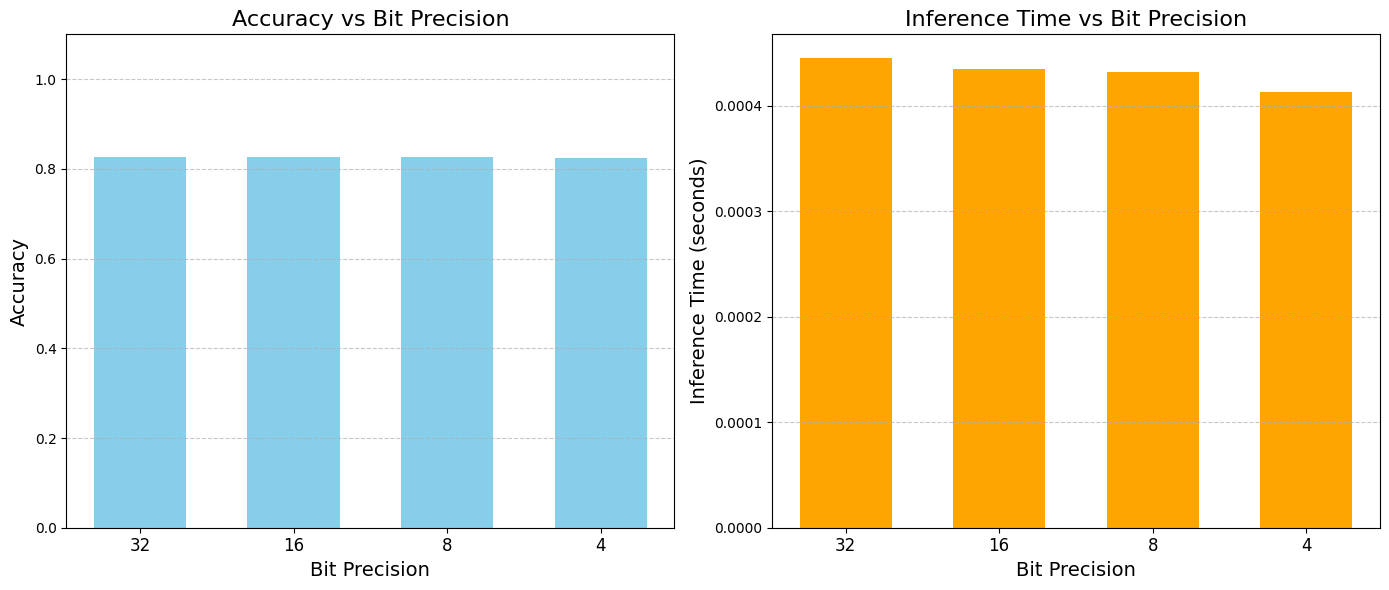

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Define bit precisions
bit_precisions = [32, 16, 8, 4]

# Initialize lists to store results
accuracies = []
inference_times = []

# Measure accuracy and inference time for each bit precision
for bit_precision in bit_precisions:
    # Ensure both X_test and y_test are on the same device
    X_test = X_test.to('cuda')
    y_test = y_test.to('cuda')  # Move y_test to GPU

    # Measure accuracy
    accuracy = evaluate_apnn(apnn_model, X_test, y_test, bit_precision)
    accuracies.append(accuracy)

    # Measure inference time
    inference_time = measure_inference_time(apnn_model, X_test, bit_precision, device='cuda')
    inference_times.append(inference_time)

    # Print results
    print(f"Bit Precision: {bit_precision}, Accuracy: {accuracy:.4f}, Inference Time: {inference_time:.6f} seconds")

# Create evenly spaced x positions
x_positions = np.arange(len(bit_precisions))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Two subplots side by side

# Plot Accuracy
ax1.bar(x_positions, accuracies, color='skyblue', width=0.6)
ax1.set_title("Accuracy vs Bit Precision", fontsize=16)
ax1.set_xlabel("Bit Precision", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=14)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(bit_precisions, fontsize=12)
ax1.set_ylim(0, 1.1)  # Assuming accuracy ranges between 0 and 1.1
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Inference Time
ax2.bar(x_positions, inference_times, color='orange', width=0.6)
ax2.set_title("Inference Time vs Bit Precision", fontsize=16)
ax2.set_xlabel("Bit Precision", fontsize=14)
ax2.set_ylabel("Inference Time (seconds)", fontsize=14)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(bit_precisions, fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()
